# Mount drive

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install required dependencies

In [11]:
!pip install -q git+https://github.com/huggingface/transformers.git timm

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [12]:
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-n27fqtm0
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-n27fqtm0


# Create dataset and dataloaders

In [13]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, ann_file, feature_extractor):
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension
        
        return pixel_values, target

In [14]:
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor()

test_dataset = CocoDetection(img_folder='/content/drive/MyDrive/road-damage-detection/detr-resnet50/val2017', 
                              ann_file='/content/drive/MyDrive/road-damage-detection/detr-resnet50/annotations/instances_val2017.json',
                              feature_extractor=feature_extractor)

train_dataset = CocoDetection(img_folder='/content/drive/MyDrive/road-damage-detection/rdd-coco/train2017',
                              ann_file='/content/drive/MyDrive/road-damage-detection/rdd-coco/annotations/custom_train.json',
                              feature_extractor=feature_extractor)

loading annotations into memory...
Done (t=1.57s)
creating index...
index created!
loading annotations into memory...
Done (t=1.26s)
creating index...
index created!


In [17]:
print('Test dataset length:', len(test_dataset))
print('Train dataset length:', len(train_dataset))

Test dataset length: 5000
Train dataset length: 6925


# Visualize random images
## Test images

Image n°465180


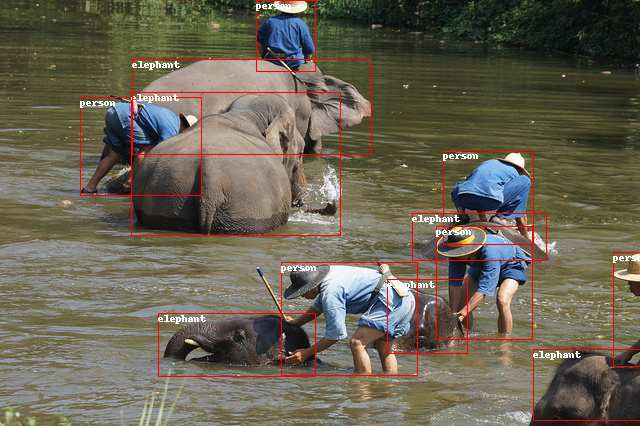

In [18]:
import numpy as np
import os
from PIL import Image, ImageDraw


image_ids = test_dataset.coco.getImgIds()

image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = test_dataset.coco.loadImgs(image_id)[0]
type(image)
image = Image.open(os.path.join('/content/drive/MyDrive/road-damage-detection/detr-resnet50/val2017', image['file_name']))
type(image)

annotations = test_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = test_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

## Train images

Image n°3578


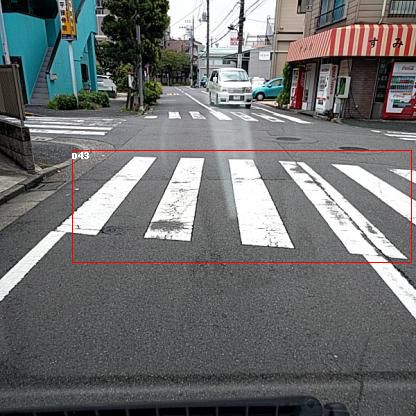

In [19]:
image_ids = train_dataset.coco.getImgIds()

image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]

image = Image.open(os.path.join('/content/drive/MyDrive/road-damage-detection/rdd-coco/train2017', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')
image



In [20]:
num_classes = 9
first_class_index = 1
finetuned_classes = [
      'D00', 'D30', 'D20', 'D10', 'D40', 'D43', 'D01', 'D11', 'D44', 'D00'
  ]

print('First class index: {}'.format(first_class_index))  
print('Parameter num_classes: {}'.format(num_classes))
print('Fine-tuned classes: {}'.format(finetuned_classes))

First class index: 1
Parameter num_classes: 9
Fine-tuned classes: ['D00', 'D30', 'D20', 'D10', 'D40', 'D43', 'D01', 'D11', 'D44', 'D00']


# Create a test dataloader

In [21]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=2)
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=2)

In [23]:
batch_test = next(iter(test_dataloader))
batch_test.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [24]:
batch_train = next(iter(train_dataloader))
batch_train.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [25]:
print(batch_test['pixel_values'].shape)
print(batch_train['pixel_values'].shape)

torch.Size([2, 3, 873, 1201])
torch.Size([2, 3, 800, 800])


In [26]:
print(batch_test['pixel_mask'].shape)
print(batch_train['pixel_mask'].shape)

torch.Size([2, 873, 1201])
torch.Size([2, 800, 800])


# Model

In [27]:
%cd /content/drive/MyDrive/road-damage-detection/detr-resnet50

/content/drive/MyDrive/road-damage-detection/detr-resnet50


In [28]:
from datasets import get_coco_api_from_dataset 
from datasets.coco_eval import CocoEvaluator

base_ds = get_coco_api_from_dataset(test_dataset)
iou_types = ['bbox']
coco_evaluator = CocoEvaluator(base_ds, iou_types)

In [29]:
base_ds_train = get_coco_api_from_dataset(train_dataset)
iou_types = ['bbox']
coco_evaluator_train = CocoEvaluator(base_ds, iou_types)

In [ ]:
from transformers import DetrForObjectDetection

model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

## Get pretrained weights

In [30]:
import torch

In [31]:
# Get pretrained weights
checkpoint = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
            map_location='cpu',
            check_hash=True)

# Remove class weights
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]

# Save
torch.save(checkpoint,
           'detr-r50_no-class-head.pth')

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth


  0%|          | 0.00/159M [00:00<?, ?B/s]

In [32]:
!python main.py \
  --dataset_file 'rdd-coco' \
  --coco_path '/content/drive/MyDrive/road-damage-detection/rdd-coco' \
  --output_dir 'outputs' \
  --resume "detr-r50_no-class-head.pth"\
  --epochs 10

Not using distributed mode
fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
git:
  sha: N/A, status: clean, branch: N/A

Namespace(aux_loss=True, backbone='resnet50', batch_size=2, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path='/content/drive/MyDrive/road-damage-detection/rdd-coco', dataset_file='rdd-coco', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=10, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_classes=None, num_queries=100, num_workers=2, output_dir='outputs', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='detr-r50_no-class-head.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start

In [ ]:
from tqdm.notebook import tqdm
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

print("Running evaluation...")

nbatches = 2

for idx, batch in enumerate(tqdm(test_dataloader)):
    
    if idx > nbatches:
        break
    
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] 

    # forward pass
    outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = feature_extractor.post_process(outputs, orig_target_sizes) # convert outputs to COCO api
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    coco_evaluator.update(res)